<a href="https://colab.research.google.com/github/taguka/whale/blob/master/baseline_martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

In [0]:
!pip install imagehash

In [0]:
!pip3 install lapjv

In [0]:
!pip3 install keras_tqdm

In [0]:
import pandas as pd
import numpy as np
import os
from PIL import Image as pil_image
from PIL.ImageDraw import Draw
from scipy.ndimage import affine_transform
from keras.models import load_model
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import PIL
from PIL import Image
from PIL.ImageDraw import Draw
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import img_to_array, array_to_img
from scipy.ndimage import affine_transform
from imagehash import phash
from math import sqrt
import pickle
import random
from keras.utils import Sequence
from lapjv  import lapjv
import time

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
!pip3 install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle competitions download -c humpback-whale-identification
!unzip -qq train.zip -d train | awk 'BEGIN {ORS=" "} {if(NR%500==0) print "."}'
!unzip -qq test.zip  -d test | awk 'BEGIN {ORS=" "} {if(NR%500==0) print "."}'
!rm train.zip
!rm test.zip

# Load Data

In [0]:
DRIVE='drive/My Drive'
TRAIN_DF ='train.csv'
SUB_Df = 'sample_submission.csv'
TRAIN = 'train/'
TEST = 'test/'

BB_DF = os.path.join(DRIVE,'bounding_boxes_0.822.csv')
P2H=os.path.join(DRIVE,'p2h.pickle')
tagged = dict([(p, w) for _, p, w in pd.read_csv(TRAIN_DF).to_records()])
submit = [p for _, p, _ in pd.read_csv(SUB_Df).to_records()]
join = list(tagged.keys()) + submit


In [0]:
img_shape = (384, 384, 1)  # The image shape used by the model
anisotropy = 2.15  # The horizontal compression ratio
crop_margin = 0.05  # The margin added around the bounding box to compensate for bounding box inaccuracy

In [0]:
train=pd.read_csv('train.csv')
test=pd.read_csv('sample_submission.csv')
p2bb = pd.read_csv(BB_DF).set_index("Image")
data_train=train.Image.tolist()
data_test=test.Image.tolist()

In [0]:
def expand_path(p):
    if os.path.isfile('train/' + p): return 'train/' + p
    if os.path.isfile('test/' + p): return 'test/' + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))
  
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result
  
# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))
  
#Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)
  
# Read an image for prediction, i.e. without data augmentation.
def read_for_prediction(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 


# Duplicated Images

In [14]:
join=data_train+data_test
p2size = {}
for p in tqdm(join):
  size = pil_image.open(expand_path(p)).size
  p2size[p] = size

100%|██████████| 33321/33321 [00:15<00:00, 2089.95it/s]


In [0]:
# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

In [0]:
if os.path.isfile(P2H):
    with open(P2H, 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())
    with open(P2H, 'wb') as f: 
      pickle.dump(p2h, f)

In [0]:
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)

Images: ['01f66ca26.jpg', 'd37179fd1.jpg']


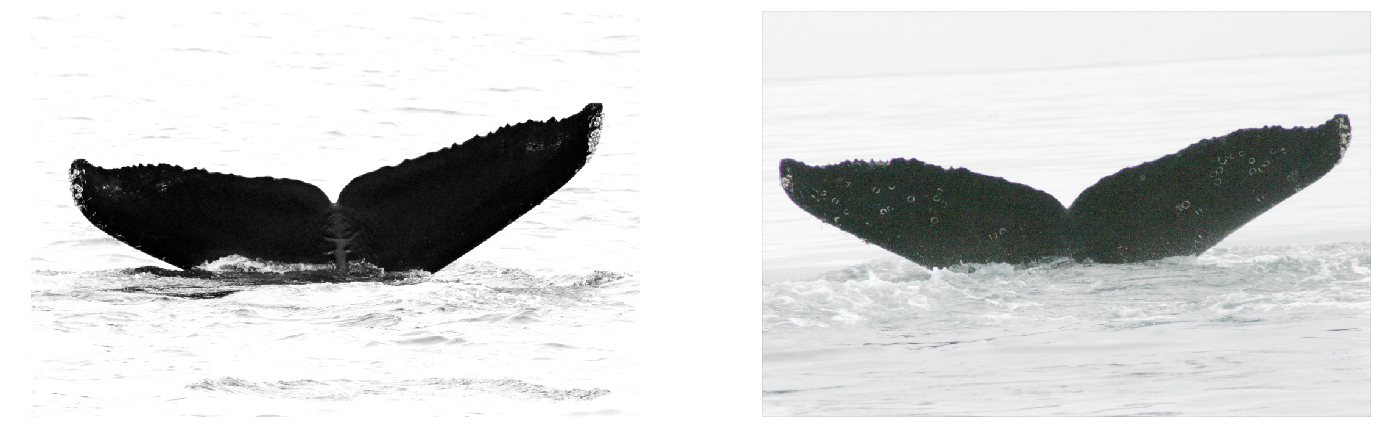

In [18]:
def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): 
      ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): 
      ax.imshow(img.convert('RGB'))
      
for h, ps in h2ps.items():
    if len(ps) > 1:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

In [0]:
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): 
  h2p[str(h)] = prefer(ps)

# Preprocessing Data

In [0]:
def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

In [0]:
def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb.loc[p]
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and convert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

In [0]:
def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

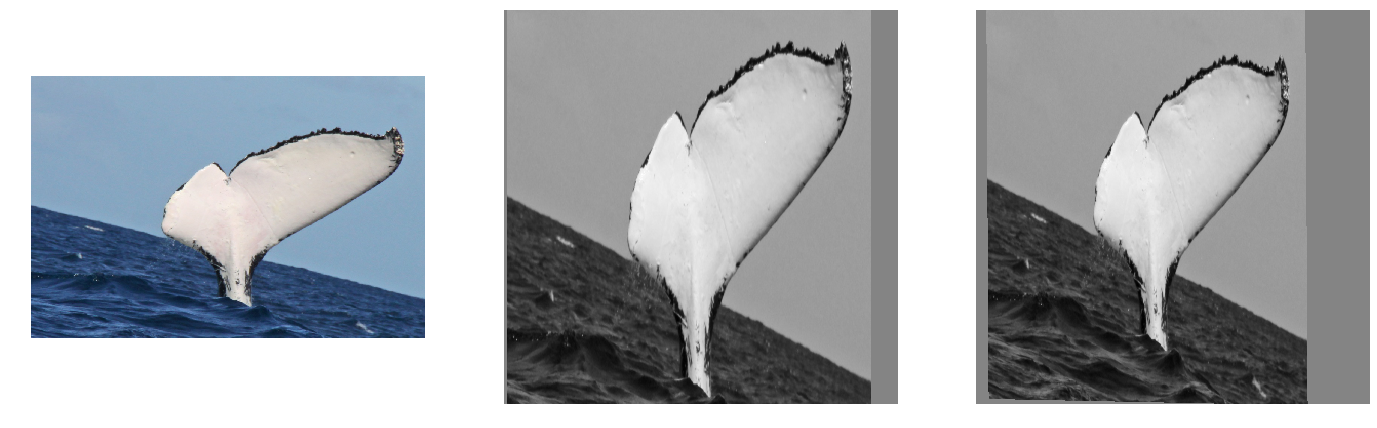

In [23]:
p = list(tagged.keys())[3000]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

In [0]:
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y)  # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y)  # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)  # no activation # Restore the number of original features
    y = Add()([x, y])  # Add the bypass connection
    y = Activation('relu')(y)
    return y


def build_model(lr, l2, activation='sigmoid'):
    ##############
    # BRANCH MODEL
    ##############
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape)  # 384x384x1
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp) # 192x192x64

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  # 48x48x128
    for _ in range(4):
        x = subblock(x, 64, **kwargs)  # 48x48x128

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  # 12x12x384
    for _ in range(4):
        x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  # 6x6x512
    for _ in range(4):
        x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    branch_model = Model(inp, x)

    ############
    # HEAD MODEL
    ############
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model


model, branch_model, head_model = build_model(64e-5, 0)

In [25]:
  model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512)          2692096     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
head (Model)                    (None, 1)            706         model_1[1][0]                    
          

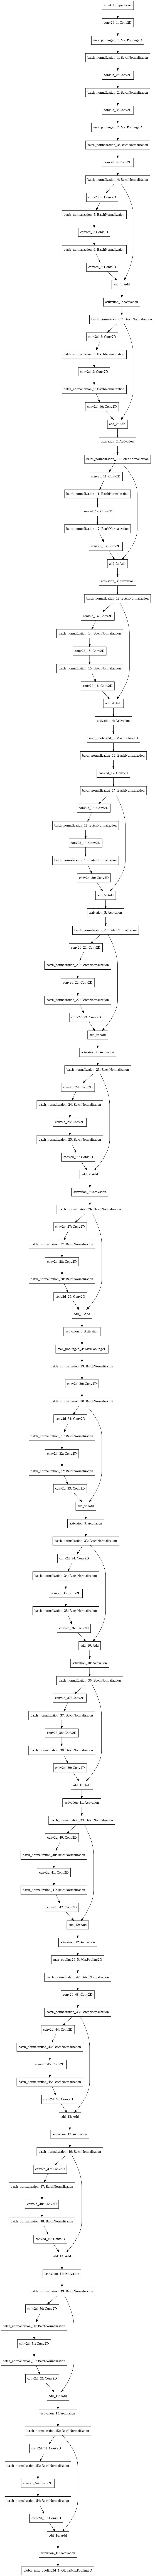

In [26]:
from keras.utils import plot_model
plot_model(branch_model, to_file='branch_model.png')
pil_image.open('branch_model.png')

# Training Data  Construction

In [0]:
# Find all the whales associated with an image id. It can be ambiguous as duplicate images may have different whale ids.
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = str(p2h[p])
        if h not in h2ws: 
          h2ws[h] = []
        if w not in h2ws[h]:
          h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)

In [28]:
len(h2ws)

15696

In [0]:
# For each whale, find the unambiguous images ids.
w2hs = {}
for h, ws in h2ws.items():
    if len(ws) == 1:  # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: 
          w2hs[w] = []
        if h not in w2hs[w]: 
          w2hs[w].append(h)
for w, hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)

In [30]:
len(w2hs)

5004

In [0]:
train = []  # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {}  # Associate the image ids from train to each whale id.
for w, hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts:
                w2ts[w] = []
            if h not in w2ts[w]:
                w2ts[w].append(h)
for w, ts in w2ts.items():
    w2ts[w] = np.array(ts)

t2i = {}  # The position in train of each training image id
for i, t in enumerate(train):
    t2i[t] = i

In [0]:
class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        """
        super(TrainingData, self).__init__()
        self.score = -score  # Maximizing the score is the same as minimuzing -score.
        self.steps = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[
                        i, j] = 10000.0  # Set a large value for matching whales -- eliminates this potential pairing
        self.on_epoch_end()

    def __getitem__(self, index):
        start = self.batch_size * index
        end = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size = end - start
        assert size > 0
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        b = np.zeros((size,) + img_shape, dtype=K.floatx())
        c = np.zeros((size, 1), dtype=K.floatx())
        j = start // 2
        for i in range(0, size, 2):
            a[i, :, :, :] = read_for_training(self.match[j][0])
            b[i, :, :, :] = read_for_training(self.match[j][1])
            c[i, 0] = 1  # This is a match
            a[i + 1, :, :, :] = read_for_training(self.unmatch[j][0])
            b[i + 1, :, :, :] = read_for_training(self.unmatch[j][1])
            c[i + 1, 0] = 0  # Different whales
            j += 1
        return [a, b], c

    def on_epoch_end(self):
        if self.steps <= 0: return  # Skip this on the last epoch.
        self.steps -= 1
        self.match = []
        self.unmatch = []
        _, x, _ = lapjv(self.score)
#cost, x, y = lap.lapjv(C)
#_, _, x = lapjv(self.score)  # Solve the linear assignment problem

        y = np.arange(len(x), dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts, d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i, j in zip(x, y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i, j)
            assert i != j
            self.unmatch.append((train[i], train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x, y] = 10000.0
        self.score[y, x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)

    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1) // self.batch_size




In [33]:
# Test on a batch of 32 with random costs.
%%time
score = np.random.random_sample(size=(len(train), len(train)))
data = TrainingData(score)
(a, b), c = data[0]

CPU times: user 14.7 s, sys: 2.01 s, total: 16.7 s
Wall time: 16.8 s


In [0]:
# A Keras generator to evaluate only the BRANCH MODEL
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.verbose = verbose
        if self.verbose > 0: self.progress = tqdm(total=len(self), desc='Features')

    def __getitem__(self, index):
        start = self.batch_size * index
        size = min(len(self.data) - start, self.batch_size)
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i, :, :, :] = read_for_validation(self.data[start + i])
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a

    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size


In [0]:
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.verbose = verbose
        if y is None:
            self.y = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0], 1)
        else:
            self.iy, self.ix = np.indices((y.shape[0], x.shape[0]))
            self.ix = self.ix.reshape((self.ix.size,))
            self.iy = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1) // self.batch_size
        if self.verbose > 0:
            self.progress = tqdm(total=len(self), desc='Scores')

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, len(self.ix))
        a = self.y[self.iy[start:end], :]
        b = self.x[self.ix[start:end], :]
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a, b]

    def __len__(self):
        return (len(self.ix) + self.batch_size - 1) // self.batch_size

In [0]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
    """
    Tranformed the packed matrix 'score' into a square matrix.
    @param score the packed matrix
    @param x the first image feature tensor
    @param y the second image feature tensor if different from x
    @result the square matrix
    """
    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Unpack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0],x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0],1)] = score.squeeze()
        m += m.transpose()
    else:
        m        = np.zeros((y.shape[0],x.shape[0]), dtype=K.floatx())
        iy,ix    = np.indices((y.shape[0],x.shape[0]))
        ix       = ix.reshape((ix.size,))
        iy       = iy.reshape((iy.size,))
        m[iy,ix] = score.squeeze()
    return m

def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the training set against every other picture O(n^2).
    """
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):
    """
    Perform training epochs
    @param step Number of epochs to perform
    @param ampl the K, the randomized component of the score matrix.
    """
    global w2ts, t2i, steps, features, score, histories
    
    # shuffle the training pictures
    random.shuffle(train)
    
    # Map whale id to the list of associated training picture hash value
    w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)

    # Map training picture hash value to index in 'train' array    
    t2i  = {}
    for i,t in enumerate(train): t2i[t] = i    

    # Compute the match score for each picture pair
    features, score = compute_score()
    
    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl*np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}'),
            ModelCheckpoint(os.path.join(DRIVE,model_name)+'_{epoch:02d}.hdf5')]).history
    steps += step
    
    # Collect history data
    history['epochs'] = steps
    history['ms'    ] = np.mean(score)
    history['lr'    ] = get_lr(model)
    print(history['epochs'],history['lr'],history['ms'])
    histories.append(history)

In [0]:
model_name = 'mpiotte-standard'
histories  = []
steps      = 0

In [0]:
if os.path.isfile(os.path.join(DRIVE,'mpiotte-standard_pretrained.model')):
    tmp = load_model(os.path.join(DRIVE,'mpiotte-standard_pretrained.model'))
    model.set_weights(tmp.get_weights())
else:
    # epoch -> 10
    make_steps(10, 1000)
    ampl = 100.0
    for _ in range(10):
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100**-0.1*ampl)
    model.save('mpiotte-standard.model')
'''    
    # epoch -> 150
    for _ in range(18): make_steps(5, 1.0)
    # epoch -> 200
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)
    # epoch -> 240
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    # epoch -> 250
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    # epoch -> 300
    weights = model.get_weights()
    model, branch_model, head_model = build_model(64e-5,0.0002)
    model.set_weights(weights)
    for _ in range(10): make_steps(5, 1.0)
    # epoch -> 350
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)    
    # epoch -> 390
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    # epoch -> 400
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    model.save('mpiotte-standard.model')
'''

In [0]:
def prepare_submission(threshold, filename):
    """
    Generate a Kaggle submission file.
    @param threshold the score given to 'new_whale'
    @param filename the submission file name
    """
    vtop = 0
    vhigh = 0
    pos = [0, 0, 0, 0, 0, 0]
    with open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i, p in enumerate(tqdm(submit)):
            t = []
            s = set()
            a = score[i, :]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop, vhigh, pos

In [0]:
# Find elements from training sets not 'new_whale'
tic = time.time()
h2ws = {}
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = str(p2h[p])
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))

# Dictionary of picture indices
h2i = {}
for i, h in enumerate(known): h2i[h] = i

# Evaluate the model.
fknown = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
score = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
score = score_reshape(score, fknown, fsubmit)

# Generate the subsmission file.
prepare_submission(0.99, 'submission.csv')
toc = time.time()
print("Submission time: ", (toc - tic) / 60.)

Scores:  18%|█▊        | 10806/61006 [03:06<14:24, 58.10it/s]

In [0]:
!cp submission.csv 'drive/My Drive/submission.csv'